## Análises de Opiniões de Avaliações de Comida co Python

O conjunto de dados analisado consiste em avaliações de comidas finas da Amazon e pode ser encontrado no seguinte endereço: https://www.kaggle.com/snap/amazon-fine-food-reviews.

## Bibliotecas importadas

In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

plt.style.use('seaborn')

## Carregamento dos dados

In [18]:
df = pd.read_csv('data/Reviews.csv')

As primeiras linhas do conjunto de dados carregados são mostradas abaixo:

In [19]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Quanto às dimensões do _dataframe_, temos 568.454 linhas (cada linha corresponde a uma avalização de um usuário) e 10 colunas (valiáveis), das quais apenas as colunas: "Score", "Summary" e "Text" contêm informações relevantes para o que se pretende fazer neste projeto.

In [20]:
df.shape

(568454, 10)

Por meio do método `info` dos _dataframes_ pandas, obtemos algumas informações a respeito do tipo de variável de cada uma das colunas do conjunto de dados:

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Análise Exploratória de Dados

Das colunas de interesse, a coluna "Score", correspondente a pontuação de 1 a 5 atribuída à comida pelo usuário, é de tipo inteiro. Para essa coluna, podemos aplicar o método `describe` que fornece um resumo estatístico de dados numéricos:

In [22]:
df['Score'].describe()

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

Note-se que a nota média foi aproximadamente igual a 4,18. O gráfico abaixo mostra que a maioria das notas é igual a 5, indicando uma boa avaliação do produto.

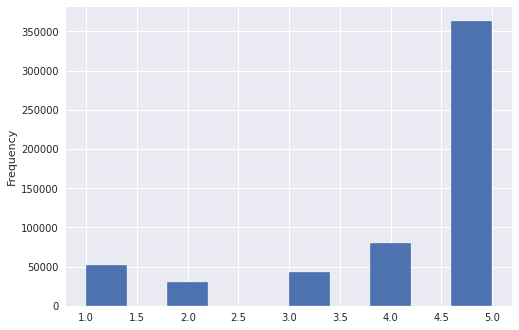

In [23]:
df['Score'].plot.hist(edgecolor='white')
plt.show()

Por outro lado, as variáveis "Summary" e "Text" são de tipo texto. Para estas variáveis se faz necessária a aplicação de técnicas de Análise de Sentimentos a fim de verificar como os clientes caracterizam os alimentos consumidos.

In [24]:
df['Summary'].head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

In [25]:
df['Text'].head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

## Processamento de Texto

A primeira tarefa nesta etapa de processamento de texto é  converter todos os caracteres da coluna "Text" para caixa baixa:

In [26]:
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

Em seguida, removemos todos os carecteres correespondentes a pontuações da mesma coluna:

In [27]:
df['Text'] = df['Text'].str.replace('[^\w\s]', "")

/tmp/ipykernel_4208/4166156605.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^\w\s]', "")


O resultado é o seguinte:

In [28]:
df['Text'].head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price there was a wide ...
Name: Text, dtype: object